In [1]:
# !pip install -q netCDF4
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
#import xscale

# load mooring data from AODN aggregated timeseries

In [2]:
#fname = 'http://thredds.aodn.org.au/thredds/dodsC/IMOS/ANMN/NSW/BMP120/aggregated_timeseries/IMOS_ANMN-NSW_TZ_20110329_BMP120_FV01_TEMP-aggregated-timeseries_END-20200327_C-20200519.nc'
#nc.to_netcdf('IMOS_ANMN-NSW_TZ_20110329_BMP120_FV01_TEMP-aggregated-timeseries_END-20200327_C-20200519.nc')

# modified to use data saved locally.
# use local file
fname = 'IMOS_ANMN-NSW_TZ_20110329_BMP120_FV01_TEMP-aggregated-timeseries_END-20200327_C-20200519.nc'
nc = xr.open_dataset(fname)

Looking at the data structure

In [3]:
nc
# *look at .nc file
#nc.NOMINAL_DEPTH[:5]
# *slice into 5 depths?
#nc.TEMP.count()
# *10584285 measurements
#nc.LATITUDE.count()    
# *378 points 378/13 = 29.07 ie 29 deployments 1 lat/long per logger
#nc.LATITUDE.head(200)
#nc.TEMP.head(20)
# *look at variable(part)

<xarray.Dataset>
Dimensions:                   (INSTRUMENT: 378, OBSERVATION: 10584285)
Coordinates:
    TIME                      (OBSERVATION) datetime64[ns] ...
    LATITUDE                  (INSTRUMENT) float64 ...
    LONGITUDE                 (INSTRUMENT) float64 ...
    NOMINAL_DEPTH             (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT, OBSERVATION
Data variables:
    TEMP                      (OBSERVATION) float32 ...
    TEMP_quality_control      (OBSERVATION) float32 ...
    DEPTH                     (OBSERVATION) float32 ...
    DEPTH_quality_control     (OBSERVATION) float32 ...
    PRES                      (OBSERVATION) float32 ...
    PRES_quality_control      (OBSERVATION) float32 ...
    PRES_REL                  (OBSERVATION) float32 ...
    PRES_REL_quality_control  (OBSERVATION) float32 ...
    instrument_index          (OBSERVATION) int16 ...
    source_file               (INSTRUMENT) |S64 ...
    instrument_id             (INSTRUMENT) |S64 ...
Attributes:
    data_centre:                   Australian Ocean Data Network (AODN)
    file_version_quality_control:  Quality controlled data have been through ...
    time_coverage_start:           2011-03-29T22:35:00Z
    rejected_files:                
    date_created:                  2020-05-19T08:47:20Z
    references:                    http://www.imos.org.au
    naming_authority:              IMOS
    source:                        Mooring
    time_coverage_end:             2020-03-27T20:24:59Z
    feature_type:                  timeSeries
    citation:                      The citation in a list of references is: "...
    keywords_vocabulary:           IMOS parameter names. See https://github.c...
    data_centre_email:             info@aodn.org.au
    geospatial_lon_max:            150.31775
    institution_references:        http://imos.org.au/facilities/aodn/
    contributor_name:              Roughan, Moninya; Austin, Timothy
    abstract:                      Aggregated Time-series Product: This file ...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    Conventions:                   CF-1.6,IMOS-1.4
    geospatial_lon_min:            150.3078333333
    geospatial_vertical_max:       nan
    geospatial_vertical_min:       nan
    contributor_email:             mroughan@unsw.edu.au; t.austin@unsw.edu.au
    keywords:                      TEMP, AGGREGATED
    history:                       2020-05-19T08:47:20Z: Aggregated file crea...
    geospatial_lat_min:            -36.21525
    author_email:                  eduardo.kleinsalas@utas.edu.au
    disclaimer:                    Data, products and services from IMOS are ...
    generating_code_version:       1.3.2
    title:                         Long Timeseries Velocity Aggregated produc...
    author:                        Klein, Eduardo
    file_version:                  Level 1 - Quality Controlled Data
    contributor_role:              principal_investigator; author
    lineage:                       The variable of interest (VoI) is produced...
    license:                       http://creativecommons.org/licenses/by/4.0/
    project:                       Integrated Marine Observing System (IMOS)
    geospatial_lat_max:            -36.2012166667
    site_code:                     BMP120
    acknowledgement:               Any users of IMOS data are required to cle...
    DODS.strlen:                   256
    DODS.dimName:                  strlen

# Neil - where are the metadata comments for each deployment gone?

Create a dataframe using the variables we want.

In [4]:
df = pd.DataFrame({'TIME': nc.TIME, 'TEMP': nc.TEMP, 'TEMPqc': nc.TEMP_quality_control, 'DEPTH' : nc.DEPTH}).set_index('TIME')
#df.head(10)
df.tail(5)

,TEMP,TEMPqc,DEPTH
TIME,,,
2020-03-27 19:55:00.000001024,16.524523,1.0,98.585770
2020-03-27 20:00:00.000003328,16.544540,1.0,98.617599
2020-03-27 20:05:00.000005632,16.469830,1.0,98.613861
2020-03-27 20:10:00.000007936,16.505842,1.0,98.653618
2020-03-27 20:15:00.000000000,16.492502,1.0,98.641747


Have a look at this dataframe and the qc flags

In [5]:
# df.head(10)
# df.TEMP.count()
df.TEMPqc.value_counts()
# Count good data points - describe qc flags!!

1.0    10457390
3.0       93366
2.0       31155
4.0        2374
Name: TEMPqc, dtype: int64

Create a dataframe using only good (qc=1) data

In [6]:
df_good = df[df.TEMPqc == 1]
df_good.TEMPqc.value_counts()

1.0    10457390
Name: TEMPqc, dtype: int64

Now lets have a look at the data distribution with depth.

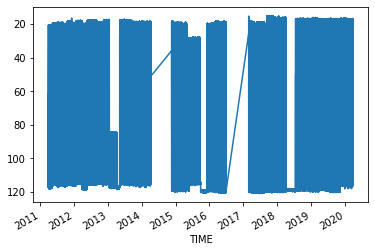

In [7]:
df_good.DEPTH.plot()
plt.gca().invert_yaxis()
# df_good.DEPTH.plot.scatter('TIME','DEPTH') syntax 

We can now have a closer look by zooming in on a slice

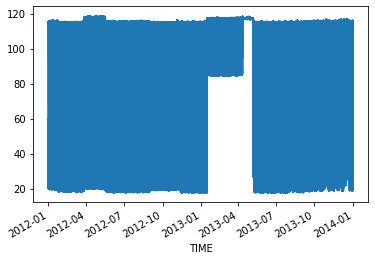

In [8]:
df_good['2012':'2013'].DEPTH.plot()
#refer appendix for datagap/interpolating discussion.

Look at distribution of depths

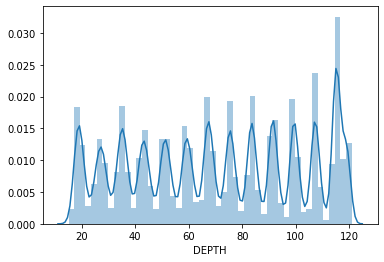

In [9]:
sns.distplot(df_good['DEPTH'].dropna())

It is interesting to look at the effects of knockdown, particularly near the surface. 

Also it looks like the mooring changed depth at some point. This is most likely when we moved onto foul ground after trawler strikes.

# Neil - I would like to scatter plot max depth vs time ( to see mooring movement)

Now lets bin the data into depth bins

In [10]:
# bin the data into depth bins (first pass), the 'labels' field gives the bins a name
#binned = pd.cut(x=df_good.DEPTH, bins=[-np.inf, 30, 60,80, np.inf], right=False, labels=['surface', '30-60', '60-80' , 'bottom'])
#grouped = df_good.groupby(binned)
#surface_temp_1D = grouped.get_group('surface').TEMP.resample('1D').mean()
#bottom_temp_1D = grouped.get_group('bottom').TEMP.resample('1D').mean()
# bin the data into depth bins (second pass)
#binned = pd.cut(x=df_good.DEPTH, bins=[-np.inf, 22, 30,38,46,54,62,70,78,86,94,102,110, np.inf], 
#                right=False, labels=['surface', '22-30', '30-38', '38-46', '46-54', '54-62', '62-70', 
#                                     '70-78', '78-86', '86-94', '94-102', '102-110' , 'bottom'])
# bin the data into depth bins (third pass)
binned = pd.cut(x=df_good.DEPTH, bins=[-np.inf, 24,32,40,48,56,64,72,81,89,97,105,112, np.inf], 
                right=False, labels=['surface', '24-32', '32-40', '40-48', '48-56', '56-64', '64-72', 
                                     '72-81', '81-89', '89-97', '97-105',  '105-112' , 'bottom'])

Lets see how these look

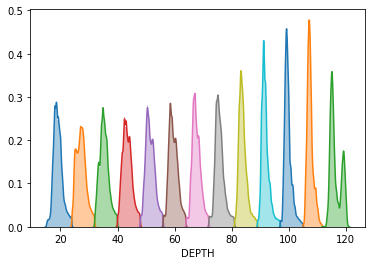

In [18]:
# plot all bins
grouped = df_good.groupby(binned)
sns.distplot(grouped.get_group('surface').DEPTH)
sns.distplot(grouped.get_group('24-32').DEPTH)
sns.distplot(grouped.get_group('32-40').DEPTH)
sns.distplot(grouped.get_group('40-48').DEPTH)
sns.distplot(grouped.get_group('48-56').DEPTH)
sns.distplot(grouped.get_group('56-64').DEPTH)
sns.distplot(grouped.get_group('64-72').DEPTH)
sns.distplot(grouped.get_group('72-81').DEPTH)
sns.distplot(grouped.get_group('81-89').DEPTH)
sns.distplot(grouped.get_group('89-97').DEPTH)
sns.distplot(grouped.get_group('97-105').DEPTH)
sns.distplot(grouped.get_group('105-112').DEPTH)
sns.distplot(grouped.get_group('bottom').DEPTH)

Now lets create sets according to these bins
(It would be nice to automate this process by finding frequency minimums)

In [20]:
surface_temp = grouped.get_group('surface').TEMP
bin24_32_temp = grouped.get_group('24-32').TEMP
bin32_40_temp = grouped.get_group('32-40').TEMP
bin40_48_temp = grouped.get_group('40-48').TEMP
bin48_56_temp = grouped.get_group('48-56').TEMP
bin56_64_temp = grouped.get_group('56-64').TEMP
bin64_72_temp = grouped.get_group('64-72').TEMP
bin72_81_temp = grouped.get_group('72-81').TEMP
bin81_89_temp = grouped.get_group('81-89').TEMP
bin89_97_temp = grouped.get_group('89-97').TEMP
bin97_105_temp = grouped.get_group('97-105').TEMP
bin105_112_temp = grouped.get_group('105-112').TEMP
bottom_temp = grouped.get_group('bottom').TEMP

Lets have a look at some plots of this data eg. top and bottom temp

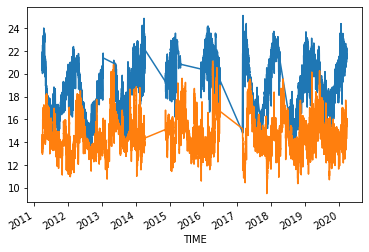

In [28]:
surface_temp.plot()
bottom_temp.plot()

Note the interpolation. Artefact?

Zoom in 

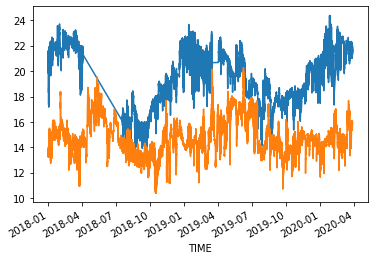

In [43]:
surface_temp['2018':'2020'].plot()
bottom_temp['2018':'2020'].plot()

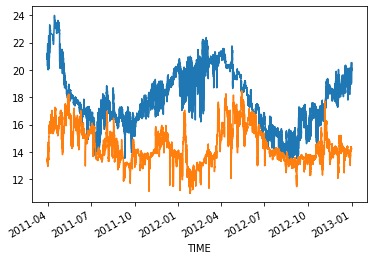

In [44]:
surface_temp['2011':'2012'].plot()
bottom_temp['2011':'2012'].plot()

Now lets compute a 1 day mean

In [45]:
grouped = df_good.groupby(binned)
surface_temp_1D = grouped.get_group('surface').TEMP.resample('1D').mean()
bin24_32_temp_1D = grouped.get_group('24-32').TEMP.resample('1D').mean()
bin32_40_temp_1D = grouped.get_group('32-40').TEMP.resample('1D').mean()
bin40_48_temp_1D = grouped.get_group('40-48').TEMP.resample('1D').mean()
bin48_56_temp_1D = grouped.get_group('48-56').TEMP.resample('1D').mean()
bin56_64_temp_1D = grouped.get_group('56-64').TEMP.resample('1D').mean()
bin64_72_temp_1D = grouped.get_group('64-72').TEMP.resample('1D').mean()
bin72_81_temp_1D = grouped.get_group('72-81').TEMP.resample('1D').mean()
bin81_89_temp_1D = grouped.get_group('81-89').TEMP.resample('1D').mean()
bin89_97_temp_1D = grouped.get_group('89-97').TEMP.resample('1D').mean()
bin97_105_temp_1D = grouped.get_group('97-105').TEMP.resample('1D').mean()
bin105_112_temp_1D = grouped.get_group('105-112').TEMP.resample('1D').mean()
bottom_temp_1D = grouped.get_group('bottom').TEMP.resample('1D').mean()

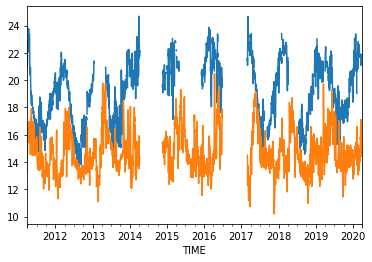

In [46]:
# Plot these
surface_temp_1D.plot()
bottom_temp_1D.plot()

Note this has got rid of joining line

Zooming in we get a nice plot now

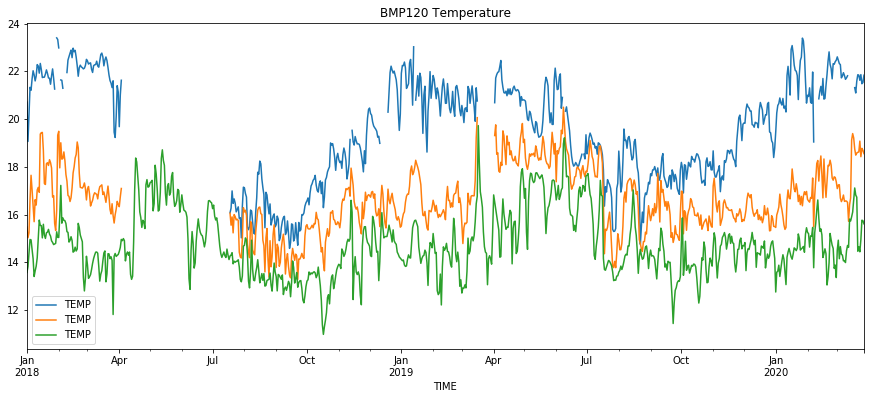

In [68]:
surface_temp_1D['2018':'2020'].plot()
bin64_72_temp_1D['2018':'2020'].plot()
bottom_temp_1D['2018':'2020'].plot(figsize=(15,6), title='BMP120 Temperature')
plt.legend()

# Neil - need help with title and y-axis label here

In [51]:
# Better graph? Bit of an aside to try and get this displaying dynamically
# Using plotly.express
import plotly.express as px
fig = px.line(surface_temp_1D,  y = "TEMP", title = 'surface temp')
fig.show()
fig = px.line(bin64_72_temp_1D,  y = "TEMP", title = '64-72m temp')
fig.show()
fig = px.line(bottom_temp_1D, y = "TEMP", title = 'bottom temp')
fig.show()

In [52]:
# How to overlay these
fig = px.line(surface_temp_1D, bottom_temp_1D,  y = "TEMP", title = 'graph2')
fig.show()

#fig = px.line(df, x="year", y="lifeExp", color='country')

In [63]:
# Nope . need to specify time vs temp??
#fig = px.line(surface_temp_1D, bottom_temp_1D,  x = "TIME",y = "TEMP", title = 'graph3') ...nope
# Question. Is surface_temp_ID still in df_good?
# Can i plot it as a subset of df_good? ie
#fig = px.line(df_good, x="TIME", y="TEMP", color='BIN')
#or something like this... ?
#df_good[["surface_temp_1D", "bottom_temp_1D"]].plot(subplots=True, figsize=(15,4))
#fig.show()

Back to reality

In [64]:
# Compute the centered 7-day rolling mean
surface_temp_7D = surface_temp_1D.rolling(7, center=True,min_periods=1).mean()
bottom_temp_7D = bottom_temp_1D.rolling(7, center=True,min_periods=1).mean()

#Compute the centered 365-day rolling mean
surface_temp_1Y = surface_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()
bottom_temp_1Y = bottom_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()

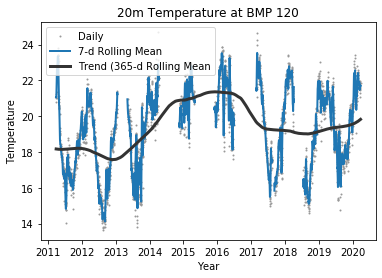

In [65]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(surface_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(surface_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(surface_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('20m Temperature at BMP 120');
#plt.savefig('BMP120_20m_temperature_tseries.png', dpi=300,bbox_inches='tight')

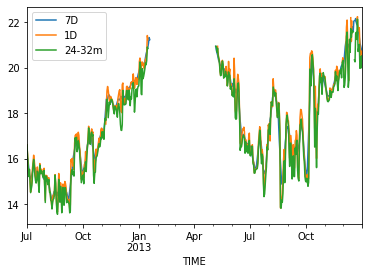

In [71]:
surface_temp_7D['2012-7':'2013'].plot(label='7D')
surface_temp_1D['2012-7':'2013'].plot(label='1D')
bin24_32_temp_1D['2012-7':'2013'].plot(label='24-32m')
plt.legend()

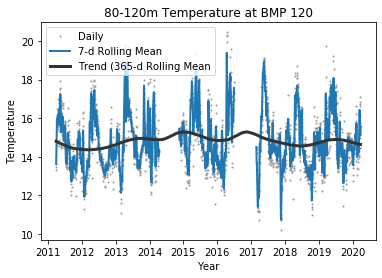

In [74]:
# NO LONGER 80-120
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(bottom_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(bottom_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(bottom_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-120m Temperature at BMP 120');
plt.savefig('BMP120_80-120m_temperature_tseries.png', dpi=300,bbox_inches='tight')

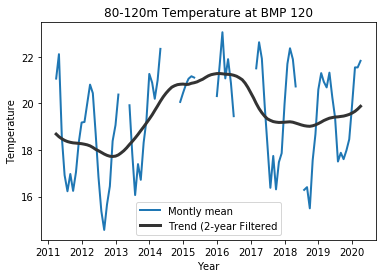

In [75]:
# NO LONGER 80-120
# resample at monthly, remove seasonal cycle, add 2 year filter
surface_temp_1M = grouped.get_group('surface').TEMP.resample('1M').mean()
bottom_temp_1M = grouped.get_group('bottom').TEMP.resample('1M').mean()

surface_temp_1M_filt = surface_temp_1M.rolling(24, center=True, win_type='hamming',min_periods=3).mean()
bottom_temp_1M_filt = bottom_temp_1M.rolling(24, center=True, win_type='hamming',min_periods=3).mean()

# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(surface_temp_1M, linewidth=2, label='Montly mean')
ax.plot(surface_temp_1M_filt, color='0.2', linewidth=3, label='Trend (2-year Filtered')
# Set x-ticks to yearly interval and add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-120m Temperature at BMP 120');

In [76]:
# OK, so this works, but if we want to keep things consistent with the SST analysis, and for gapfilling lets rather convert to an Xarray dataset and proceed from there.
DA_surfacetemp = surface_temp_1D.to_xarray()
ds = DA_surfacetemp.to_dataset()
ds = ds.rename({'TIME': 'time'})
ds

<xarray.Dataset>
Dimensions:  (time: 3287)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-29 2011-03-30 ... 2020-03-27
Data variables:
    TEMP     (time) float32 20.816395 20.996569 ... 21.531096 21.837227

In [77]:
# Remove seasonal cycle

def xarray_trend(xarr):
    """
    Calculates the trend of the data along the 'time' dimension
    of the input array (xarr).
    USAGE:  x_DS = xarray_trend(xarr)
    INPUT:  xarr is an xarray DataArray with dims:
                time, [lat, lon]
                where lat and/or lon are optional
    OUTPUT: xArray Dataset with:
                original xarr input
                slope
                p-value
    TODO?
    There could be speed improvements (using numpy at the moment)
    """

    from scipy import stats
    # getting shapes

    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    # intercept = ym - (slope * xm)
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr.to_dataset(name=xarr.name)
    # first create variable for slope and adjust meta
    out['slope'] = xarr[:2].mean('time').copy()
    out['slope'].name += '_slope'
    out['slope'].attrs['units'] = 'units / day'
    out['slope'].values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    out['pval'] = xarr[:2].mean('time').copy()
    out['pval'].name += '_Pvalue'
    out['pval'].values = p.reshape(xarr.shape[1:])
    out['pval'].attrs['info'] = ("If p < 0.05 then the results "
                                 "from 'slope' are significant.")

    return out

<xarray.Dataset>
Dimensions:  (time: 3287)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-29 2011-03-30 ... 2020-03-27
Data variables:
    TEMP     (time) float32 20.816395 20.996569 ... 21.531096 21.837227
    slope    float64 0.0004396
    pval     float64 5.465e-39

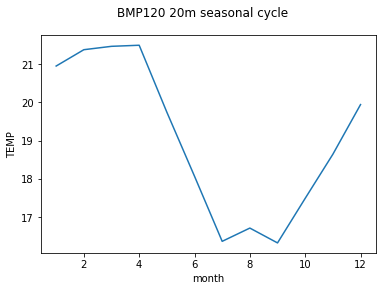

In [78]:
climatology = ds.TEMP.groupby('time.month').mean('time')
anomalies = ds.TEMP.groupby('time.month') - climatology
climatology.plot()
#get linear trend
trend = xarray_trend(ds.TEMP)
plt.suptitle("BMP120 20m seasonal cycle")
plt.savefig('BMP120_20m_seasonal_cycle.png', dpi=300,bbox_inches='tight')
trend

In [79]:
decade_trend = trend.slope*3650
decade_trend

<xarray.DataArray 'slope' ()>
array(1.60454857)

<bound method DataArray.to_netcdf of <xarray.DataArray 'TEMP' (time: 3287)>
array([-0.6552563 , -0.4750824 , -0.32242584, ...,  0.00853539,
        0.05944443,  0.3655758 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-29 2011-03-30 ... 2020-03-27
    month    (time) int64 3 3 3 4 4 4 4 4 4 4 4 4 4 ... 3 3 3 3 3 3 3 3 3 3 3 3>

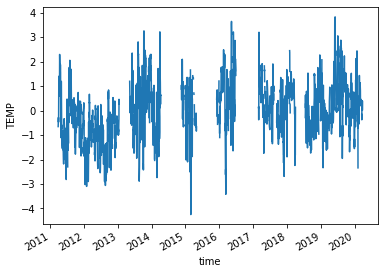

In [80]:
BMP_120_anomalies = anomalies
BMP_120_anomalies.plot()
BMP_120_anomalies.to_netcdf

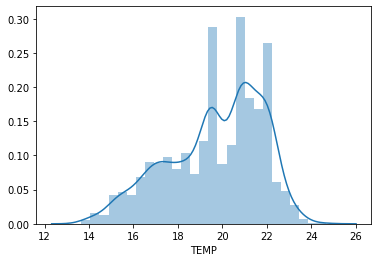

In [81]:
y = surface_temp_1D.fillna(surface_temp_1D.ffill())
sns.distplot(y)

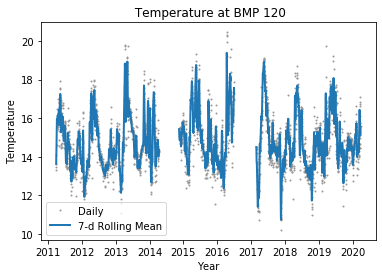

In [82]:
# NO LONGER 80-120
# Plot all
fig, ax = plt.subplots()
ax.plot(bottom_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(bottom_temp_7D, linewidth=2, label='7-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title(' Temperature at BMP 120');
plt.savefig('BMP120_80-120m_temperature_tseries.png', dpi=300,bbox_inches='tight')

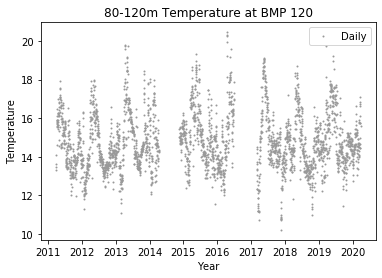

In [83]:
# NO LONGER 80-120
# Plot 1 year
fig, ax = plt.subplots()
ax.plot(bottom_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
# ax.plot(bottom_temp_7D, linewidth=2, label='7-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-120m Temperature at BMP 120');
plt.savefig('BMP120_80-120m_temperature_tseries.png', dpi=300,bbox_inches='tight')

Future Work:
-Looking from perspective of an outside data user it is not easily apparent why data is missing. There are some comments in metadata but they will be entered when data is first processed and there may be information come to light later.

- Where are the comments in aggregated dataset?

 - Also how has it has been interpolated if at all. eg. some of the data gaps in graphs above have a line joining, some dont?
 
- possible solution for discussion - interpolated data should be included with data set. This data should have a flag that identifies itself as interpolated data eg qc=0 whereby the dataset is full if using (qc=0,1). Also the metadata of interpolated data should contain description of why that section has been interpolated (eg mooring loss, instrument failure etc)
Solves a number of problems - skewed trends from missing a whole season, information loss moving to aggregated dataset, coding problem with NaNs, and strange interpolation artefacts depending on OS.



